## Step 1: Import Libraries
We begin by importing the necessary libraries: PyTorch for building and training the neural network, and NumPy for handling the dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import csv
import os
import pandas as pd
import json

from time import sleep

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras.models import Sequential
# import tensorflow as tf
# from keras.api.models import Sequential
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor

2024-11-14 12:14:07.957876: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 12:14:08.520564: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 12:14:13.836328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 12:14:22.540174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Step 2: Define Hyperparameters

In [2]:
# Number of models in the federated learning setup
NUM_MODELS = 5
# Number of previous time points used for forecasting the next point
PREVIOUS_LAG = 5
# Number of epochs for training
EPOCHS = 50
# Interval at which to save weights
SAVE_INTERVAL = 1
# Initial learning rate
LEARNING_RATE = 0.01

## Step 3: Create Dataset Directories and CSV Files
We create separate directories for each model, and each directory contains a unique univariate time series dataset.

In [3]:
# Create directories for each model dataset
for i in range(NUM_MODELS):
    directory = f'model_{i}_data'
    if not os.path.exists(directory):
        os.makedirs(directory)

# Create example univariate time series data and save to CSV files
np.random.seed(0)
for i in range(NUM_MODELS):
    data = np.sin(np.linspace(0, 50, 150) + np.random.normal(0, 0.5, 150))  # Generate sine wave with noise
    df = pd.DataFrame(data, columns=['value'])
    df.to_csv(f'model_{i}_data/time_series.csv', index=False)

# Create dedicated central test dataset
central_test_data = np.sin(np.linspace(0, 50, 150) + np.random.normal(0, 0.5, 150))  # Generate sine wave with noise
central_test_df = pd.DataFrame(central_test_data, columns=['value'])
central_test_df.to_csv('central_test_data.csv', index=False)

# df
# central_test_data
# central_test_df

## Step 4: Load Data into Training and Test Sets
We load the univariate time series data and prepare the training and test sets for each model. We use the defined lag to create input-output pairs for auto-regression.

In [4]:
# Function to create input-output pairs for auto-regression
def create_lagged_features(data, lag):
    x, y = [], []
    for i in range(len(data) - lag):
        x.append(data[i:i + lag])
        y.append(data[i + lag])
    return np.array(x), np.array(y)

# Prepare training and test sets for each model
datasets = []
for i in range(NUM_MODELS):
    # Load time series data
    df = pd.read_csv(f'model_{i}_data/time_series.csv')
    data = df['value'].values

    # Create lagged features
    x, y = create_lagged_features(data, PREVIOUS_LAG)

    # Split into training (80%) and test (20%) sets
    train_size = int(0.8 * len(x))
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Save datasets
    np.save(f'model_{i}_data/x_train.npy', x_train)
    np.save(f'model_{i}_data/y_train.npy', y_train)
    np.save(f'model_{i}_data/x_test.npy', x_test)
    np.save(f'model_{i}_data/y_test.npy', y_test)

    datasets.append((x_train, y_train, x_test, y_test))

# Prepare central test set
central_test_df = pd.read_csv('central_test_data.csv')
central_test_data = central_test_df['value'].values
x_central_test, y_central_test = create_lagged_features(central_test_data, PREVIOUS_LAG)
np.save('x_central_test.npy', x_central_test)
np.save('y_central_test.npy', y_central_test)

## Step 5: Define the Neural Network
We define a neural network with two hidden layers. The input size is determined by the `PREVIOUS_LAG` hyperparameter.

In [5]:
# Define the neural network
class ComplexNet(nn.Module):
    def __init__(self, input_size):
        super(ComplexNet, self).__init__()
        self.hidden1 = nn.Linear(input_size, 10)
        self.bn1 = nn.BatchNorm1d(10)
        self.hidden2 = nn.Linear(10, 5)
        self.bn2 = nn.BatchNorm1d(5)
        self.output = nn.Linear(5, 1)
        
        # Initialize weights
        nn.init.kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        nn.init.xavier_uniform_(self.output.weight)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.hidden1(x)))
        x = torch.relu(self.bn2(self.hidden2(x)))
        x = self.output(x)
        return x

In [6]:
class Container(BaseEstimator):
    def __init__(self, estimator = LinearRegression()): self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def score(self, X, y):
        return self.estimator.score(X,y)

In [7]:
def base_model(optimizer = 'adam', activation = 'relu', loss = 'mean_absolute_error'):
    model = Sequential()
    model.add(Dense(32, input_shape=(5,), kernel_initializer = 'normal', activation = activation))
    model.add(Dense(units=25, activation=activation))
    model.add(Dense(units=15, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer = optimizer, loss=loss)

    return model

#convert pandas dataframe to numpy arrays. x and contains the predictors and the response vars respectively.
def convert_to_nparray(df,corr_ids):
    y = np.array(df.response).reshape(-1,1)
    temp = []
    for i in range(0,len(df.columns)):
        if df.columns[i] in corr_ids:
            temp.append(np.array(df.loc[:, df.columns[i]]))
    x = np.stack(temp).T
    return x, y

In [13]:
class Forcaster():
    def __init__(self, x, y, isTest, df, contributing_clients):
        if isTest:
            self.x = x
            self.y = y
        else:
            self.x, self.y = convert_to_nparray(df, contributing_clients)
        self.pipeline = Pipeline([('scaler', StandardScaler()), ('clf', Container())])
        self.params = [
            {
                'clf__estimator': [LinearRegression()]
            },
            {
                    'clf__estimator': [SVR()],
                    'clf__estimator__C': [0.3,1, 1.3],
                    'clf__estimator__kernel': ['poly', 'rbf'],
                    'clf__estimator__gamma': [0.001, 0.0001],
                    'clf__estimator__degree': [2, 3]
            }
            ,{
                    'clf__estimator': [SGDRegressor()],
                    'clf__estimator__loss': ['huber'],
                    'clf__estimator__early_stopping': [True],
                    'clf__estimator__learning_rate': ['adaptive']
            },
            # {
            #         'clf__estimator': [KerasRegressor(model=base_model, activation='relu', optimizer='adam', loss='mean_absolute_error')],
            #         'clf__estimator__optimizer': ['adam', 'rmsprop'],
            #         'clf__estimator__epochs': [50],
            #         'clf__estimator__batch_size': [int(len(self.x) / NUM_MODELS)],
            #         'clf__estimator__activation': ['relu', 'tanh'],
            #         'clf__estimator__loss': ['mean_absolute_error'],
            #         'clf__estimator__verbose': [1]
            # }
            {
                    'clf__estimator': [KerasRegressor(model=base_model, activation='relu', optimizer='adam', loss='mean_absolute_error')],
                    'clf__estimator__optimizer': ['adam', 'rmsprop'],
                    'clf__estimator__epochs': [50],
                    'clf__estimator__batch_size': [int(len(self.x) / NUM_MODELS)],
                    'clf__estimator__activation': ['relu', 'tanh'],
                    'clf__estimator__loss': ['mean_absolute_error'],
                    'clf__estimator__verbose': [1]
            }
        ]

    def find_best_forecaster(self):
        gs = GridSearchCV(self.pipeline, param_grid=self.params, n_jobs=1, cv=5, return_train_score=False, scoring='neg_mean_squared_error')
        gs.fit(self.x, np.ravel(self.y))

        # self.model = gs.best_estimator_
        return gs.best_estimator_

In [ ]:
class PhysicalClient:
    id = None
    last_value = 0

    def __init__(self, id) -> None:
        if type(id) == str:
            self.id = json.loads(id)
        else:
            self.id = id
        self.training_data = None

    def __saveGet(self, *args):
        obj = self.id
        for key in args:
            if not key in obj:
                return None
            obj = obj[key]
        return obj
    
    def location(self):
        """
        returns a list of [latitude, longitude]
        """
        return self.__saveGet("location")
    
    def getID(self):
        return self.id
    
    def update_interval(self, ui = 5, unit = "minutes"):
        if unit in ("minutes", "minute", "m"):
            return ui * 60
        if unit in ("hours", "hour", "h"):
            return ui * 3600
        return ui
    
    def training_data():
        def fget(self):
            return self._training_data
        def fset(self, value):
            self._training_data = value
        def fdel(self):
            del self._training_data
        
        return locals()
    training_data = property(**training_data())

In [ ]:
class VirtualClient(PhysicalClient):
    thread = None
    update_interval = 300 #5 minutes
    counter = 0
    stop_running = False
    model = None
    contributing_clients = {}
    ordered_contributing_client_ids = []
    replaced_client_id = ""
    aligned_training_data = None
    forecasting_callback = None

    # additional info
    platform = None
    stream = None
    observation = None

    def __init__(self, id, contributing_clients, update_interval = 300, replaced_client_id = "", aligned_training_data = None, forecasting_callback = None):
        PhysicalClient.__init__(self, id)
        self.update_interval = update_interval
        self.contributing_clients = contributing_clients
        self.replaced_client_id = replaced_client_id
        self.aligned_training_data = aligned_training_data
        self.forecasting_callback = forecasting_callback

        for cs in contributing_clients:
            self.ordered_contributing_client_ids.append(cs)
        self.ordered_contributing_client_ids.sort()

    def stop(self):
        self.stop_running = True

    def train(self, on_completion = None):
        if not self.aligned_training_data:
            print("Error: No training data found. Unable to train.")
            return
        
        print("{} in being trained...".format(self.getID()))
        df, corr_clients = self.aligned_training_data
        self.model = Forcaster(df, corr_clients).find_best_forecaster()
        print("{} model created".format(self.getID()))
        if on_completion:
            on_completion(self)
        self.execute()

    def execute(self):
        while not self.stop_running:
            self.counter += 1
            if self.counter == self.update_interval:
                self.counter = 0
                try:
                    self.predict()
                except:
                    print("Error: forecating values at sensor {} failed".format(self.getID()))
            sleep(1.0)
        print("{} stopped".format(self.getID()))
    
    def update_value(self, client_id, value):
        """
        Update the value of a contributing client
        """
        for cs in self.contributing_clients:
            if self.contributing_clients[cs].getID() == client_id:
                self.contributing_clients[cs].last_value = value
                print("Updated last value for {} to {} as {}".format(client_id, value, cs))

    def forecast(self):
        values = []
        for cs_id in self.ordered_contributing_client_ids:
            if cs_id in self.contributing_clients:
                values.append(self.contributing_clients[cs_id].last_value)
        
        forecast = self.model.forecast([values])
        if self.forecasting_callback:
            self.forecasting_callback(self, forecast)

## Step 6: Train Multiple Models Independently and Save Weights
We instantiate and train `NUM_MODELS` separate models using the corresponding datasets. During training, we save the weights of each model at every training round to a separate CSV file.


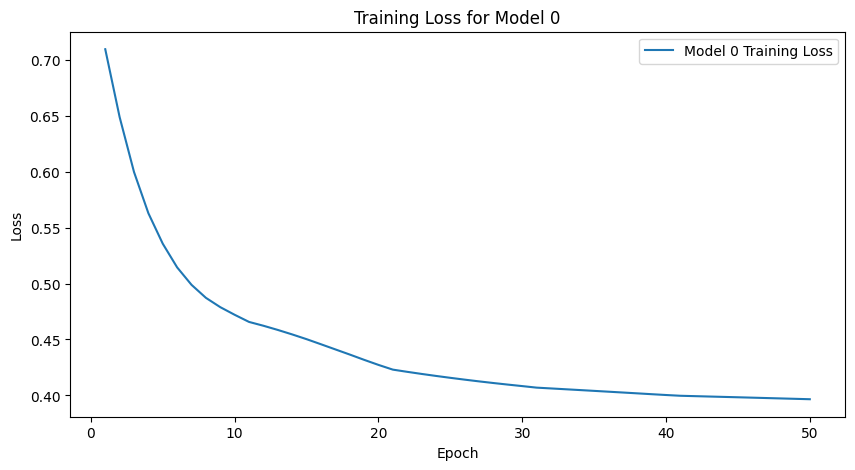

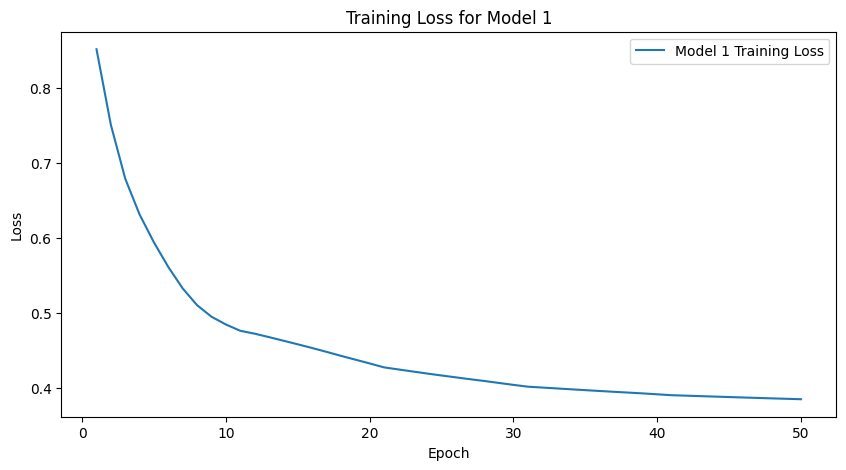

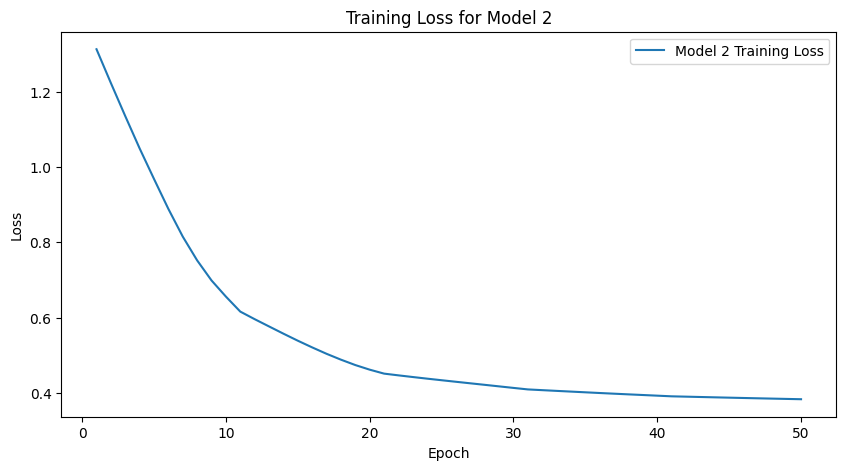

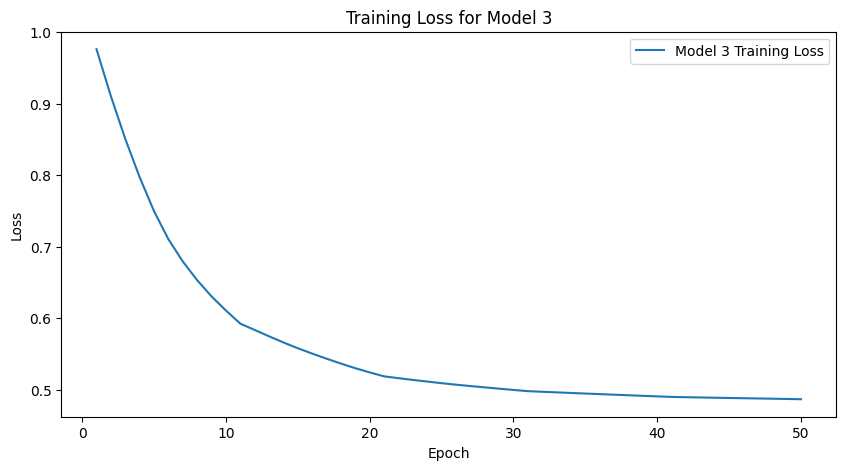

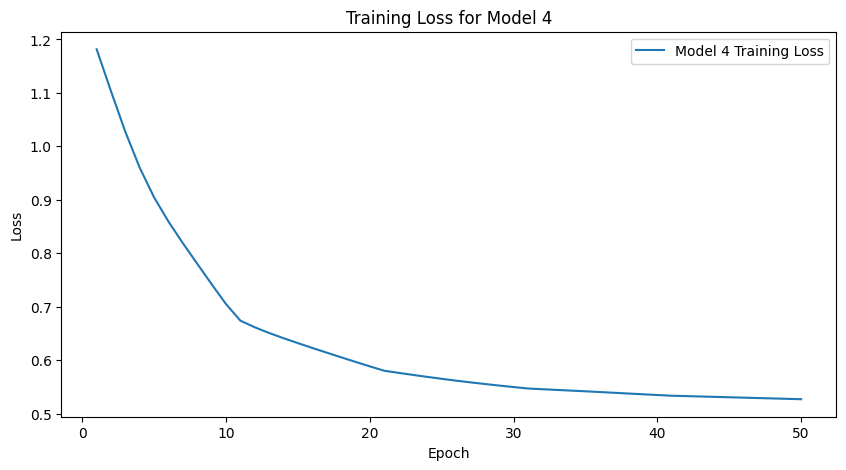

In [9]:
# Function to train a single model and save weights
def train_model(model_id):
    # Load dataset for the model
    directory = f'model_{model_id}_data'
    x_train = np.load(os.path.join(directory, 'x_train.npy'))
    y_train = np.load(os.path.join(directory, 'y_train.npy'))
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    model = ComplexNet(input_size=PREVIOUS_LAG)
    criterion = lambda output, target: torch.sqrt(nn.MSELoss()(output, target))
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    csv_filename = f'weights_tracking_model_{model_id}.csv'
    training_losses = []
    for epoch in range(1, EPOCHS + 1):
        # Forward pass
        outputs = model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        training_losses.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Save weights at intervals
        if epoch % SAVE_INTERVAL == 0:
            # Extract weights and flatten them
            weights_list = []
            for name, param in model.named_parameters():
                if param.requires_grad:
                    weights_list.extend(param.data.view(-1).tolist())

            # Check if CSV file exists
            file_exists = os.path.isfile(csv_filename)

            # Open CSV file to save weights
            with open(csv_filename, mode='a', newline='') as file:
                writer = csv.writer(file)

                # If file doesn't exist, write the header
                if not file_exists:
                    header = []
                    for name, param in model.named_parameters():
                        if param.requires_grad:
                            num_weights = param.data.numel()
                            header.extend([f'{name}_weight_{i}' for i in range(num_weights)])
                    writer.writerow(header)

                # Write weights to CSV
                writer.writerow(weights_list)

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, EPOCHS + 1), training_losses, label=f'Model {model_id} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training Loss for Model {model_id}')
    plt.show()

    return model


# Train NUM_MODELS models independently and save their weights
models = [train_model(i) for i in range(NUM_MODELS)]

## Step 7: Load Weights from CSV Files and Compute the Average Weights
We load the weights from the CSV files of the trained models, compute their average, and assign the averaged weights to a central model.

In [10]:
central_model = ComplexNet(input_size=PREVIOUS_LAG)

# Load weights from CSV files and compute the average weightsP
with torch.no_grad():
    for name, param in central_model.named_parameters():
        weights = []
        param_shape = param.data.size()
        for i in range(NUM_MODELS):
            csv_filename = f'weights_tracking_model_{i}.csv'
            if not os.path.isfile(csv_filename):
                continue  # Skip if the CSV file does not exist
            with open(csv_filename, mode='r') as file:
                reader = csv.reader(file)
                next(reader)  # Skip header
                last_row = None
                for row in reader:
                    last_row = row
                if last_row:
                    # Ensure the number of elements matches the parameter size
                    if len(last_row) == param.numel():
                        weights.append(torch.tensor([float(w) for w in last_row], dtype=torch.float32).view(param_shape))
        if weights:
            # Compute the average weight
            avg_weight = torch.stack(weights).mean(dim=0)
            param.copy_(avg_weight)

## Step 8: Use the Central Model to Make Predictions on the Central Test Set
Finally, we use the central model to make predictions on the central test set and compute the loss.

In [27]:
# Load central test set
x_central_test = np.load('x_central_test.npy')
y_central_test = np.load('y_central_test.npy')
x_central_test_tensor = torch.tensor(x_central_test, dtype=torch.float32)
y_central_test_tensor = torch.tensor(y_central_test, dtype=torch.float32).view(-1, 1)

# Make predictions on the central test set and compute loss
central_model.eval()
criterion = lambda output, target: torch.sqrt(nn.MSELoss()(output, target))
with torch.no_grad():
    test_predictions = central_model(x_central_test_tensor)
    test_loss = criterion(test_predictions, y_central_test_tensor)
    print("Test Loss on Central Test Set:", test_loss.item())

Test Loss on Central Test Set: 0.8257670402526855


In [16]:
x_central_test

forecaster = Forcaster(x_central_test, y_central_test, True, None, None)
model = forecaster.find_best_forecaster()
print("Model name and params: {}".format(model.get_params))
test_predictions = model.predict(x_central_test)
test_loss = mean_squared_error(y_central_test, test_predictions, squared=False)
print("Test Loss on Central Test Set with Forcaster:", test_loss.item())

Epoch 1/50
4/4 [==============================] - 0s 2ms/step - loss: 0.6173
Epoch 2/50
4/4 [==============================] - 0s 1ms/step - loss: 0.5945
Epoch 3/50
4/4 [==============================] - 0s 1ms/step - loss: 0.5744
Epoch 4/50
4/4 [==============================] - 0s 1ms/step - loss: 0.5498
Epoch 5/50
4/4 [==============================] - 0s 2ms/step - loss: 0.5261
Epoch 6/50
4/4 [==============================] - 0s 2ms/step - loss: 0.5027
Epoch 7/50
4/4 [==============================] - 0s 2ms/step - loss: 0.4807
Epoch 8/50
4/4 [==============================] - 0s 2ms/step - loss: 0.4550
Epoch 9/50
4/4 [==============================] - 0s 1ms/step - loss: 0.4339
Epoch 10/50
4/4 [==============================] - 0s 1ms/step - loss: 0.4080
Epoch 11/50
4/4 [==============================] - 0s 1ms/step - loss: 0.3827
Epoch 12/50
4/4 [==============================] - 0s 2ms/step - loss: 0.3533
Epoch 13/50
4/4 [==============================] - 0s 1ms/step - loss: 0.

## Step 9: Plot Weight Columns from a Weight Tracking CSV File
We create a function to plot only the nodes in the last layer of the network to visualize how these specific weights evolve over time.

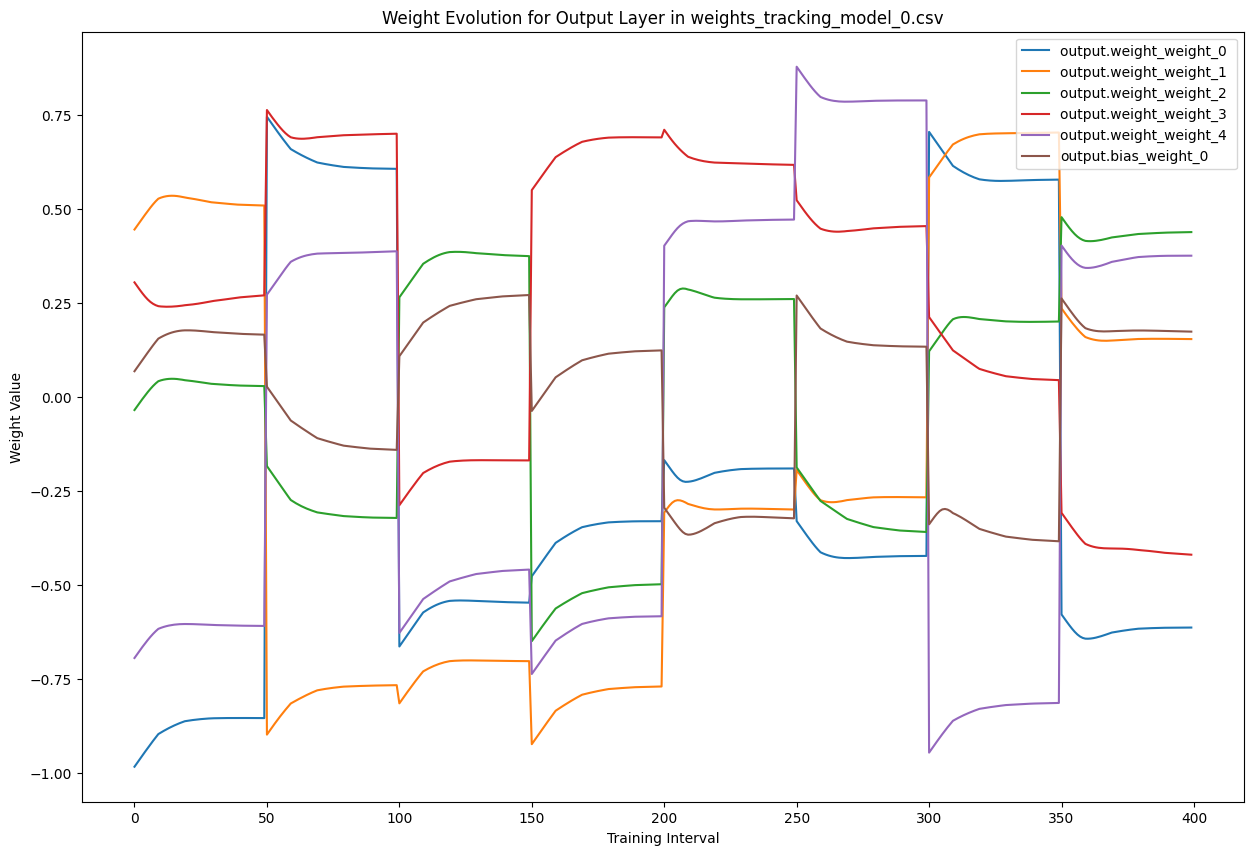

In [17]:
# Function to plot weights in the last layer of the network from a weight tracking CSV file
def plot_last_layer_weights(csv_filename):
    if not os.path.isfile(csv_filename):
        print(f"File {csv_filename} does not exist.")
        return

    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_filename)

    # Filter columns corresponding to the output layer weights
    output_layer_columns = [col for col in df.columns if col.startswith('output')]
    df_output_weights = df[output_layer_columns]

    # Plot each weight in the output layer
    plt.figure(figsize=(15, 10))
    for column in df_output_weights.columns:
        plt.plot(df_output_weights[column], label=column)

    plt.xlabel('Training Interval')
    plt.ylabel('Weight Value')
    plt.title(f'Weight Evolution for Output Layer in {csv_filename}')
    plt.legend()
    plt.show()

# Plot weights for the last layer of a specific model
plot_last_layer_weights('weights_tracking_model_0.csv')